In [1]:
import numpy as np
import pandas as pd
import pickle
import sys
import os
import dsc
from dsc.query_engine import Query_Processor as dscQP
from dsc import dsc_io

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 300)

import utils

In [38]:
def stratify_dfcol(df, colname, value):
    #return pd_utils.select_dfrows(df, [f"$({colname}) == {value}"])
    return df.loc[df[colname] == value]

def stratify_dfcols(df, condition_list):
    for (colname, value) in condition_list:
        df = stratify_dfcol(df, colname, value)
    return df

def stratify_dfcols_in_list(df, colname, values):
    return df.loc[df[colname].isin(values)]

In [12]:
dsc_output = "/home/saikatbanerjee/scratch/work/gradvi-experiments/trendfiltering"
dsc_fname  = os.path.basename(os.path.normpath(dsc_output))
db = os.path.join(dsc_output, dsc_fname + ".db")
elbopkl   = os.path.join("../dsc/results", dsc_fname + "_elbo.pkl")
dscoutpkl = os.path.join("../dsc/results", dsc_fname + "_dscout.pkl")
dscout    = pd.read_pickle(dscoutpkl)

refresh_pickle = False

print(db)
plotprefix = "compare_elbo_rmse_trendfiltering"

/home/saikatbanerjee/scratch/work/gradvi-experiments/trendfiltering/trendfiltering.db


In [20]:
target = ["simulate", "simulate.n", "simulate.strue", "simulate.snr", "simulate.sfix", "simulate.degree", "fit"]
condition = [""]

In [35]:
qp = dscQP(db, target, condition)
qp_df = qp.output_table

def read_trendfiltering_degree(df):
    qp_df_dict = df.to_dict()
    degree_fprefix_dict = qp_df_dict['simulate.degree:output']
    degree_dict = dict()
    for key, fprefix in degree_fprefix_dict.items():
        fname = os.path.join(dsc_output, f"{fprefix}.pkl")
        data = dsc_io.load_dsc(fname)
        degree_dict[key] = data['degree']
    qp_df_dict['simulate.degree'] = degree_dict
    return pd.DataFrame.from_dict(qp_df_dict)

df = read_trendfiltering_degree(qp_df)
df

,DSC,simulate,simulate.strue,simulate.snr:output,simulate.sfix,simulate.output.file,simulate.n,simulate.degree:output,fit,fit.output.file,simulate.degree
0,1,changepoint,0.1,changepoint/changepoint_1,4,changepoint/changepoint_1,1024,changepoint/changepoint_1,mr_ash,mr_ash/changepoint_1_mr_ash_1,0
1,1,changepoint,0.1,changepoint/changepoint_2,8,changepoint/changepoint_2,1024,changepoint/changepoint_2,mr_ash,mr_ash/changepoint_2_mr_ash_1,0
2,1,changepoint,0.1,changepoint/changepoint_3,16,changepoint/changepoint_3,1024,changepoint/changepoint_3,mr_ash,mr_ash/changepoint_3_mr_ash_1,0
3,1,changepoint,0.1,changepoint/changepoint_4,4,changepoint/changepoint_4,1024,changepoint/changepoint_4,mr_ash,mr_ash/changepoint_4_mr_ash_1,1
4,1,changepoint,0.1,changepoint/changepoint_5,8,changepoint/changepoint_5,1024,changepoint/changepoint_5,mr_ash,mr_ash/changepoint_5_mr_ash_1,1
...,...,...,...,...,...,...,...,...,...,...,...
355,10,changepoint,0.1,changepoint/changepoint_86,8,changepoint/changepoint_86,1024,changepoint/changepoint_86,gradvi_compound,gradvi_compound/changepoint_86_gradvi_compound_1,1
356,10,changepoint,0.1,changepoint/changepoint_87,16,changepoint/changepoint_87,1024,changepoint/changepoint_87,gradvi_compound,gradvi_compound/changepoint_87_gradvi_compound_1,1
357,10,changepoint,0.1,changepoint/changepoint_88,4,changepoint/changepoint_88,1024,changepoint/changepoint_88,gradvi_compound,gradvi_compound/changepoint_88_gradvi_compound_1,2
358,10,changepoint,0.1,changepoint/changepoint_89,8,changepoint/changepoint_89,1024,changepoint/changepoint_89,gradvi_compound,gradvi_compound/changepoint_89_gradvi_compound_1,2


In [36]:
dscout

,DSC,simulate,simulate.n,simulate.strue,simulate.snr,simulate.sfix,simulate.degree,fit,fit.DSC_TIME,mse.err,coef_mse.err
0,1,changepoint,1024,0.1,12.695328,4,0,mr_ash,4.182000,0.011741,NaN
1,1,changepoint,1024,0.1,37.017989,8,0,mr_ash,3.147000,0.032006,NaN
2,1,changepoint,1024,0.1,36.706472,16,0,mr_ash,2.582000,0.034879,NaN
3,1,changepoint,1024,0.1,105.356586,4,1,mr_ash,13.068000,0.026517,NaN
4,1,changepoint,1024,0.1,321.648153,8,1,mr_ash,0.632000,0.216016,NaN
...,...,...,...,...,...,...,...,...,...,...,...
715,10,changepoint,1024,0.1,1063.749561,8,1,gradvi_compound,336.549829,NaN,0.139670
716,10,changepoint,1024,0.1,2173.417891,16,1,gradvi_compound,366.318416,NaN,0.642413
717,10,changepoint,1024,0.1,4173.402625,4,2,gradvi_compound,405.450012,NaN,0.600804
718,10,changepoint,1024,0.1,5236.725997,8,2,gradvi_compound,336.505302,NaN,1.279760


In [47]:
def read_result(df, method):
    '''
    must be a single row after method selection
    '''
    dfm = stratify_dfcol(df, "fit", method)
    assert(dfm.shape[0] == 1)
    fprefix = dfm['fit.output.file'].values[0]
    ext = 'pkl' if method.startswith('gradvi') else 'rds'
    fname = os.path.join(dsc_output, f"{fprefix}.{ext}")
    data = dsc_io.load_dsc(fname)
    return data


def get_elbo_from_result(data, method):
    if method.startswith('gradvi'):
        return data['model']['elbo_path'][-1]
    else:
        return data['model']['fit']['varobj'][-1]
    
def get_convergence_from_result(data, method, mrash_maxiter = 2000):
    '''
    1: converged
    2: abnormal termination
    3: number of iterations reached limit
    4: unknown
    '''
    if method.startswith('gradvi'):
        success = data['model']['success']
        if success:
            conv_status = 1
        else:
            conv_message = data['model']['fitobj']['message']
            if "ITERATIONS REACHED LIMIT" in conv_message:
                conv_status = 3
            elif "ABNORMAL_TERMINATION_IN_LNSRCH" in conv_message:
                conv_status = 2
            else:
                conv_status = 4
    else:
        niter = data['model']['fit']['iter']
        if niter == mrash_maxiter:
            conv_status = 3
        else:
            conv_status = 1
    return conv_status

def get_mse_from_dscout(df, sfix, pve, dsc, method):
    dfrows = stratify_dfcols(df, 
                             [("simulate.sfix", sfix), 
                              ("simulate.degree", pve), 
                              ("DSC", dsc), 
                              ("fit", method)])
    mse = dfrows[~dfrows['mse.err'].isnull()]['mse.err'].values
    if len(mse) == 1:
        return mse[0]
    else:
        print ("Error fetching value")
        return mse[0]
    
def get_elbodf(df):
    methods = df['fit'].unique()
    sfixs   = df['simulate.sfix'].unique()
    pves    = df['simulate.degree'].unique()
    resdict = {'simulate.sfix': [], 'simulate.degree': [], 'DSC': [], 
               **{x: [] for x in methods}, 
               **{f"{x}_status": [] for x in methods}
              }
    for pve in pves:
        for sfix in sfixs:
            dfs = stratify_dfcols(df, [('simulate.sfix', sfix), ("simulate.degree", pve)])

            dscids = dfs['DSC'].unique()
            for idsc in dscids:
                dfs0 = stratify_dfcol(dfs, 'DSC', idsc)
                resdict['simulate.sfix'].append(sfix)
                resdict['simulate.degree'].append(pve)
                resdict['DSC'].append(idsc)
                for method in methods:
                    data = read_result(dfs0, method)
                    elbo = get_elbo_from_result(data, method)
                    conv_status = get_convergence_from_result(data, method)
                    resdict[method].append(elbo)    
                    resdict[f"{method}_status"].append(conv_status)
    return pd.DataFrame.from_dict(resdict)

def get_msedf(elbodf, dscdf):
    methods = [x[:-7] for x in list(elbodf.columns) if x.endswith("_status")]
    msedict = elbodf.to_dict()
    ikeys = list(msedict['simulate.sfix'].keys())
    for method in methods:
        for i in ikeys:
            mse = get_mse_from_dscout(dscout, 
                          msedict['simulate.sfix'][i], 
                          msedict['simulate.degree'][i],
                          msedict['DSC'][i], 
                          method)
            msedict[method][i] = mse
    return pd.DataFrame.from_dict(msedict)

def outlier_index(data):
    q3, q1 = np.percentile(data, [75, 25])
    iqr = q3 - q1
    xmin = q1 - 1.5 * iqr
    xmax = q3 + 1.5 * iqr
    keepidx = np.where(np.logical_and(data >= xmin, data <= xmax))
    outlieridx = np.where(np.logical_or(data < xmin, data > xmax))
    return outlieridx, keepidx

def outlier_index_normal(data, factor = 0.9):
    q3, q1 = np.percentile(data, [75 ,25])
    iqr = q3 - q1
    # In ANY normal distribution: IQR = Q3 - Q1 = 0.67448σ - (-0.67448σ) = 1.34896σ
    iqr_sigma = iqr / 1.34896
    median = np.median(data)
    xmin = median - factor * iqr_sigma
    xmax = median + factor * iqr_sigma
    keepidx = np.where(np.logical_and(data >= xmin, data <= xmax))
    outlieridx = np.where(np.logical_or(data < xmin, data > xmax))
    return outlieridx, keepidx

In [48]:
refresh_pickle = False

if refresh_pickle:
    elbodf = get_elbodf(df)
    elbodf.to_pickle(elbopkl)
else:
    elbodf = pd.read_pickle(elbopkl)

In [49]:
elbodf

,simulate.sfix,simulate.degree,DSC,mr_ash,mr_ash_lasso_init,gradvi_direct,gradvi_compound,mr_ash_status,mr_ash_lasso_init_status,gradvi_direct_status,gradvi_compound_status
0,4,0,1,-822.047815,-863.990709,-892.988381,-896.696578,1,1,3,1
1,4,0,2,-588.692980,-834.658741,-857.119635,-849.292667,1,1,1,1
2,4,0,3,-661.031138,-813.057618,-838.977951,-842.018958,1,1,3,1
3,4,0,4,-246.838551,-864.568004,-898.609274,-890.643348,1,1,1,1
4,4,0,5,-794.487156,-819.296391,-840.329221,-817.450978,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
85,16,2,6,964.381954,701.219949,2743.865862,1918.300532,1,3,1,3
86,16,2,7,923.849880,-67.189805,3509.414041,3059.720426,1,3,3,3
87,16,2,8,1142.660791,310.639918,3426.027515,2330.225785,1,3,1,3
88,16,2,9,1060.033701,111.051141,1773.920075,2546.527494,1,3,3,3


In [50]:
msedf = get_msedf(elbodf, dscout)

In [51]:
msedf

,simulate.sfix,simulate.degree,DSC,mr_ash,mr_ash_lasso_init,gradvi_direct,gradvi_compound,mr_ash_status,mr_ash_lasso_init_status,gradvi_direct_status,gradvi_compound_status
0,4,0,1,0.011741,0.010148,0.010332,0.010157,1,1,3,1
1,4,0,2,0.017110,0.010018,0.009888,0.009974,1,1,1,1
2,4,0,3,0.014644,0.011276,0.011285,0.011230,1,1,3,1
3,4,0,4,0.035579,0.010845,0.010828,0.010849,1,1,1,1
4,4,0,5,0.011585,0.010243,0.010251,0.010274,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
85,16,2,6,0.333299,0.009961,0.194549,0.129616,1,3,1,3
86,16,2,7,0.340078,0.010406,0.179265,0.073963,1,3,3,3
87,16,2,8,0.528767,0.010796,0.153177,0.138027,1,3,1,3
88,16,2,9,0.421809,0.010250,0.194780,0.110216,1,3,3,3


In [52]:
## Drop rows which did not converge
def filter_convergence_status(df, methods = [], remove_status = [2, 3, 4]):
    if len(methods) == 0:
        methods = [x[:-7] for x in list(df.columns) if x.endswith("_status")]
    for method in methods:
        for sidx in remove_status:
            df = df[df[f"{method}_status"] != sidx]
    return df
elbodf_filtered = filter_convergence_status(elbodf, remove_status = [2, 4])
msedf_filtered  = filter_convergence_status(msedf,  remove_status = [2, 4])
elbodf_filtered

,simulate.sfix,simulate.degree,DSC,mr_ash,mr_ash_lasso_init,gradvi_direct,gradvi_compound,mr_ash_status,mr_ash_lasso_init_status,gradvi_direct_status,gradvi_compound_status
0,4,0,1,-822.047815,-863.990709,-892.988381,-896.696578,1,1,3,1
1,4,0,2,-588.692980,-834.658741,-857.119635,-849.292667,1,1,1,1
2,4,0,3,-661.031138,-813.057618,-838.977951,-842.018958,1,1,3,1
3,4,0,4,-246.838551,-864.568004,-898.609274,-890.643348,1,1,1,1
4,4,0,5,-794.487156,-819.296391,-840.329221,-817.450978,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
85,16,2,6,964.381954,701.219949,2743.865862,1918.300532,1,3,1,3
86,16,2,7,923.849880,-67.189805,3509.414041,3059.720426,1,3,3,3
87,16,2,8,1142.660791,310.639918,3426.027515,2330.225785,1,3,1,3
88,16,2,9,1060.033701,111.051141,1773.920075,2546.527494,1,3,3,3


In [53]:
msedf_filtered

,simulate.sfix,simulate.degree,DSC,mr_ash,mr_ash_lasso_init,gradvi_direct,gradvi_compound,mr_ash_status,mr_ash_lasso_init_status,gradvi_direct_status,gradvi_compound_status
0,4,0,1,0.011741,0.010148,0.010332,0.010157,1,1,3,1
1,4,0,2,0.017110,0.010018,0.009888,0.009974,1,1,1,1
2,4,0,3,0.014644,0.011276,0.011285,0.011230,1,1,3,1
3,4,0,4,0.035579,0.010845,0.010828,0.010849,1,1,1,1
4,4,0,5,0.011585,0.010243,0.010251,0.010274,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
85,16,2,6,0.333299,0.009961,0.194549,0.129616,1,3,1,3
86,16,2,7,0.340078,0.010406,0.179265,0.073963,1,3,3,3
87,16,2,8,0.528767,0.010796,0.153177,0.138027,1,3,1,3
88,16,2,9,0.421809,0.010250,0.194780,0.110216,1,3,3,3


In [54]:
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 300)

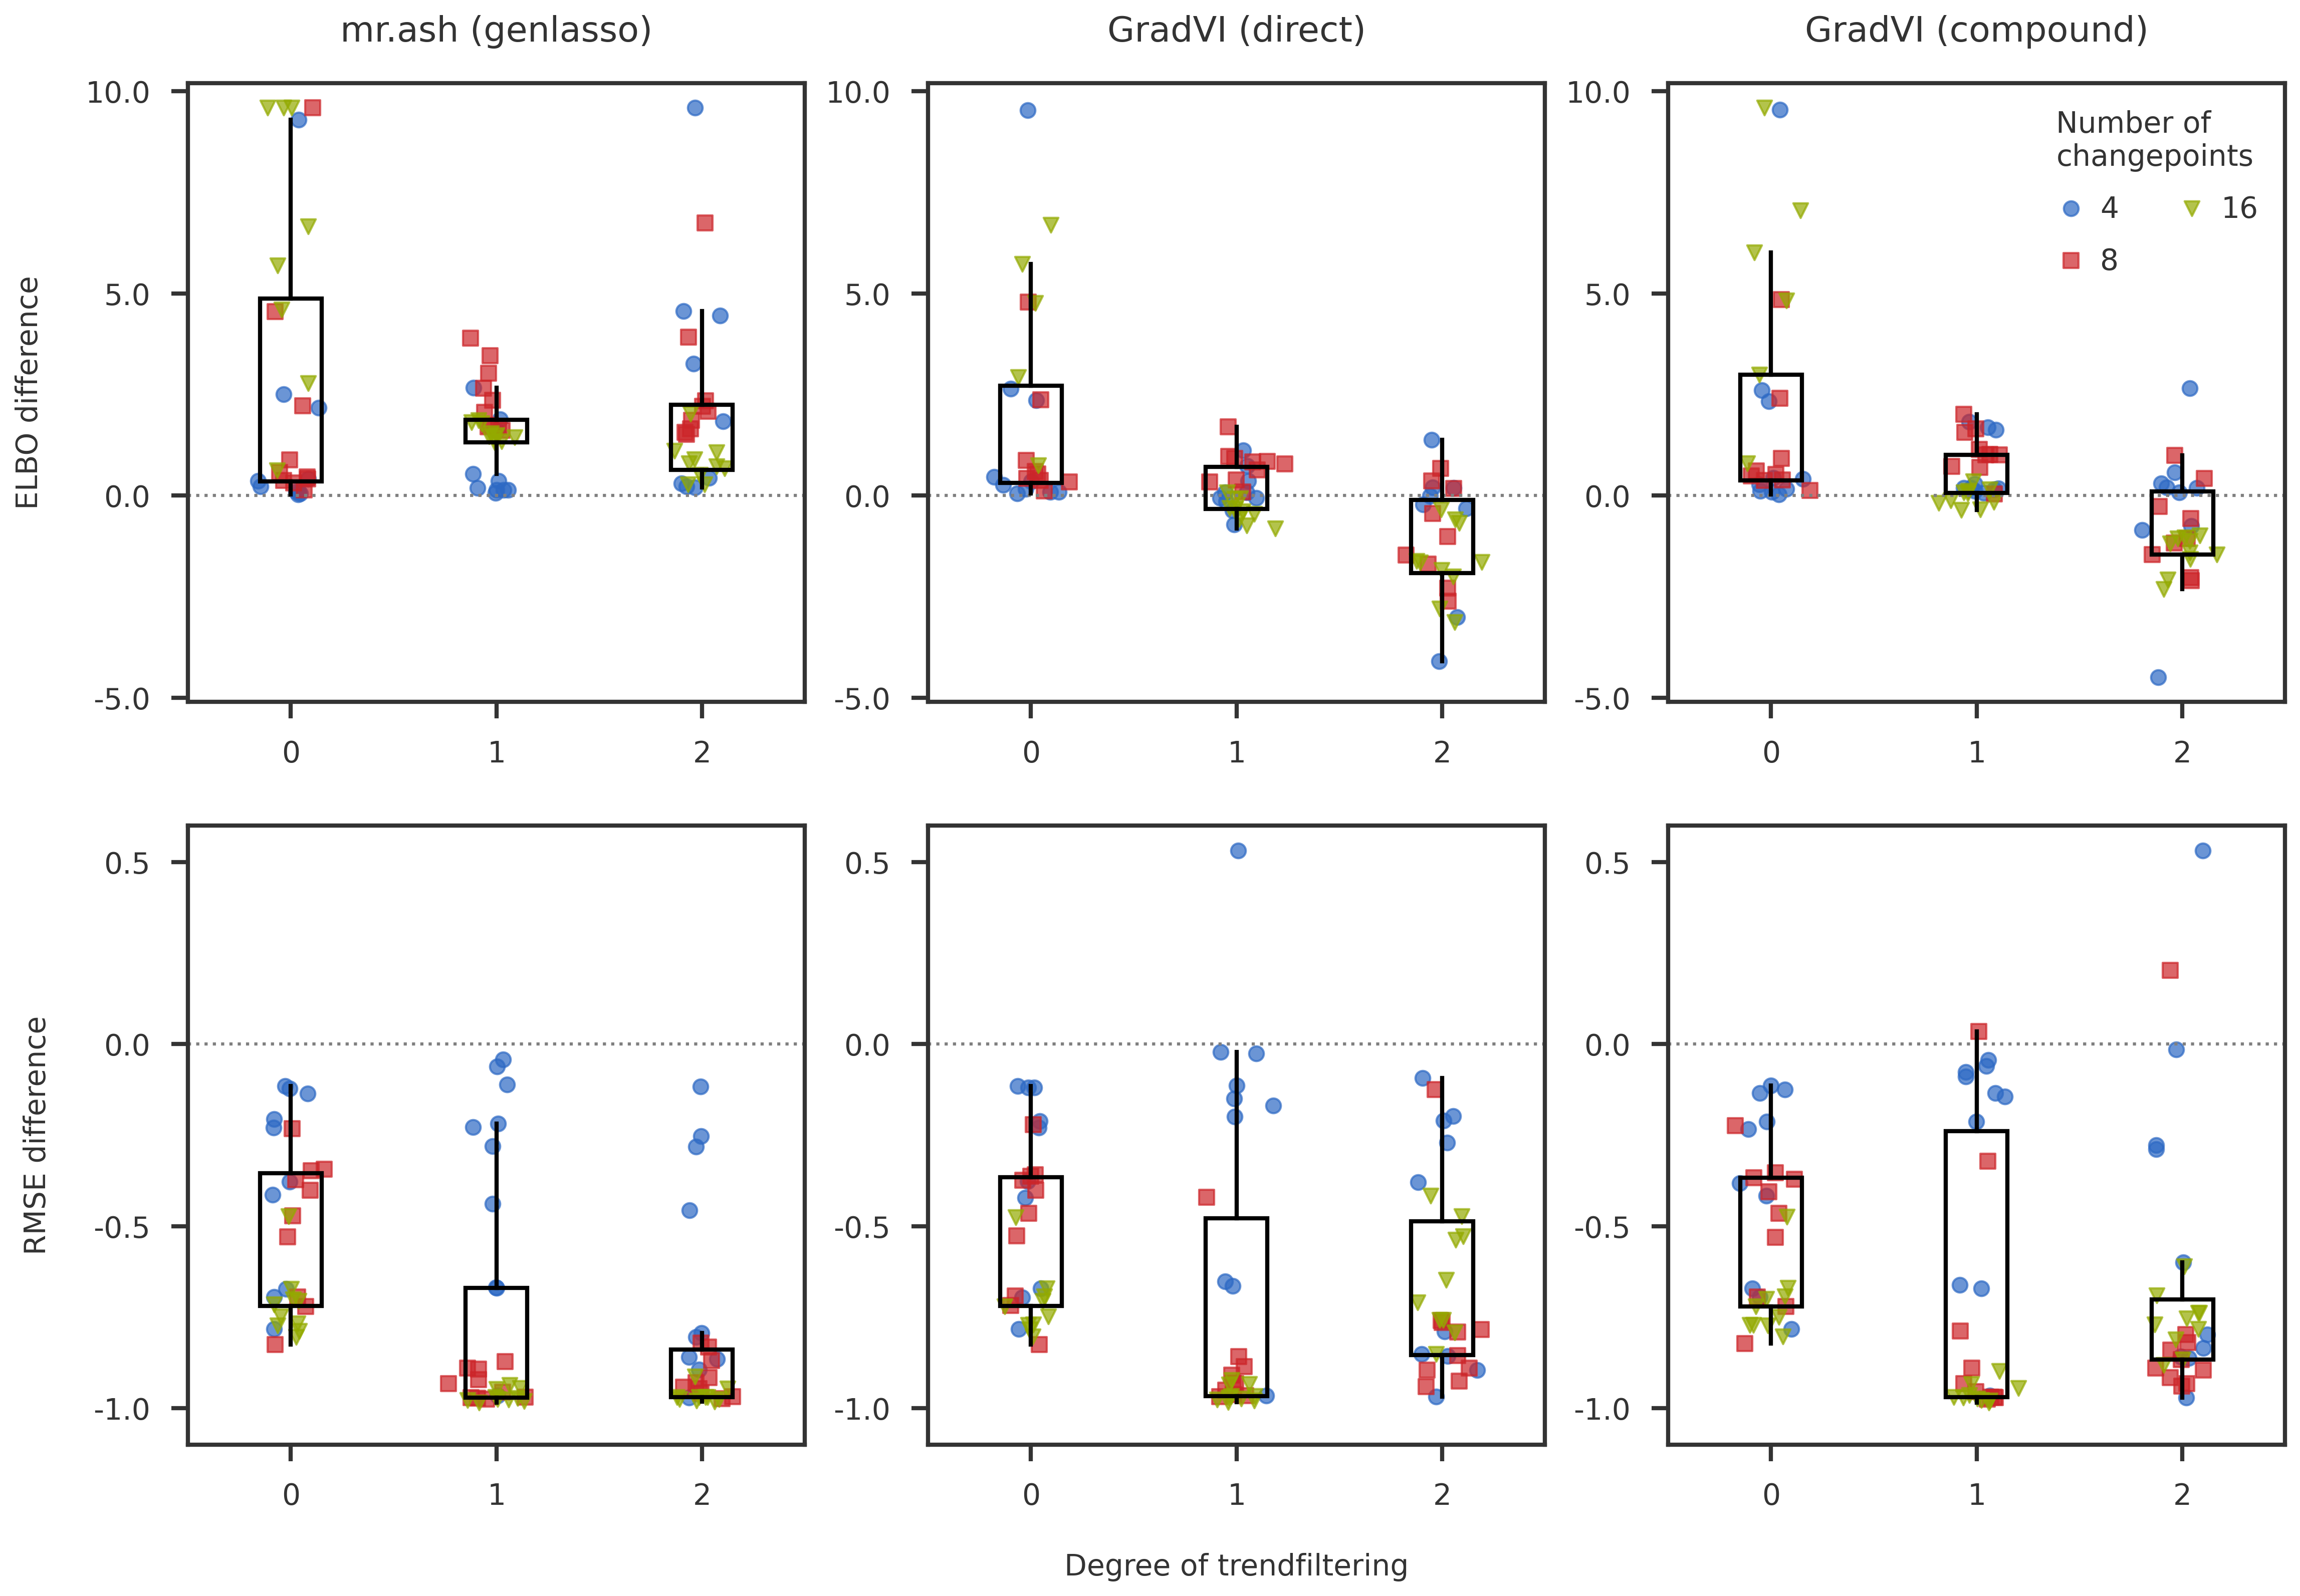

In [74]:
def np_categorize(arr):
    unq = np.unique(arr)
    d1  = {x : i for i, x in enumerate(unq)}
    d2  = {i : x for i, x in enumerate(unq)}
    return np.array([d1[x] for x in arr]), d2

def rand_jitter(arr, d = 0.04):
    stdev = d * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def truncate_jitter(arr, ylim, d = 0.04):
    xnew  = arr.copy()
    if ylim is not None:
        ydev  = d * (ylim[1] - ylim[0])
        ilow  = np.where(xnew < ylim[0] + ydev)[0]
        ihigh = np.where(xnew > ylim[1] - ydev)[0]
        if len(ilow) > 0:
            xnew[ilow]  = ylim[0] + ydev #+ np.abs(np.random.randn(len(ilow))) * ydev
        if len(ihigh) > 0:
            xnew[ihigh] = ylim[1] - ydev
    return xnew

def match_index(idx1, idx2):
    return np.intersect1d(idx1, idx2, assume_unique = True)

def plot_elbo_boxplot(ax, df, reference, target, 
                      factr = -1,
                      has_outliers = False, use_gradvi_alternate = False,
                      showboxplot = True, showscatter = True, showlegend = True,
                      ylim = None, debug = False):

    ref  = factr * df[reference].to_numpy()
    tgt  = factr * df[target].to_numpy()
    diff = (tgt - ref) / np.abs(ref)

    sfixidx, sfixvals = np_categorize(df['simulate.sfix'].to_numpy())
    pveidx,  pvevals  = np_categorize(df['simulate.degree'].to_numpy())

    if has_outliers:
        iremove = np.array([])
        ikeep   = np.arange(diff.shape[0])
    else:
        iremove, ikeep = outlier_index_normal(diff, factor = 10.0)
        if debug:
            print (f"Number of outliers removed : {iremove[0].shape[0]}")
            for i in iremove[0]:
                print(f"Index {i},\tPVE={pvevals[pveidx[i]]}, s={sfixvals[sfixidx[i]]}\t diff = {diff[i]:g}")

    ax.axhline(y = 0, linestyle = 'dotted', color = 'gray')
    if ylim is not None: ax.set_ylim(ylim)
    xvals = list(pvevals.keys())
    xlabels = list(pvevals.values())

    # Box plot for each PVE
    if showboxplot:
        boxcolor = '#000000'
        boxface = f'#{boxcolor[1:]}00' #https://stackoverflow.com/questions/15852122/hex-transparency-in-colors
        #boxface = 'white'
        medianprops = dict(linewidth=0, color = boxcolor)
        whiskerprops = dict(linewidth=2, color = boxcolor)
        boxprops = dict(linewidth=2, color = boxcolor, facecolor = boxface)
        flierprops = dict(marker='o', markerfacecolor=boxface, markersize=3, markeredgecolor = boxcolor)

        ax.boxplot([diff[match_index(np.where(pveidx == i)[0], ikeep)] for i in xvals],
                   positions = xvals,
                   showcaps = False, showfliers = False, 
                   widths = 0.3, patch_artist = True, notch = False,
                   flierprops = flierprops, boxprops = boxprops, 
                   medianprops = medianprops, whiskerprops = whiskerprops)      

    # Scatter plot with jitter, showing sfix
    if showscatter:
        mcolors  = mpl_stylesheet.banskt_colors()
        mmarkers = ['o', 's', 'v', '^', '<', '>', 'p', 'h', 'H', 'D', 'd']
        xpve = rand_jitter(pveidx)
        diff_trunc = truncate_jitter(diff, ylim)
        for sidx, sfix in sfixvals.items():
            marker  = mmarkers[sidx]
            color   = mcolors[sidx]
            _idx    = np.where(sfixidx == sidx)[0]
            _ikeep  = np.intersect1d(_idx, ikeep, assume_unique = True)
            ax.scatter(xpve[_ikeep], diff_trunc[_ikeep], marker = marker, c = color,
                       alpha = 0.7, s = 50, linewidth = 1, label = f"{sfix}")
        # legend for number of causal predictors
        if showlegend:
            mhandles, mlabels = ax.get_legend_handles_labels()
            leg1 = ax.legend(handles = mhandles, labels = mlabels, title = "Number of\nchangepoints",
                             loc = 'upper right', bbox_to_anchor = (0.98, 0.98), ncol = 2)
            leg1._legend_box.align = "left"
            
    ax.set_xticks(xvals)
    ax.set_xticklabels(xlabels)
    #mpl_utils.set_yticks(ax, scale = 'linear', spacing = 'linear', fmt = '{:.1f}')
    mpl_utils.set_yticks(ax, scale = 'linear', spacing = 'linear')

fig = plt.figure(figsize = (18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

#elbo_ylim = None #[-2.1, 1.2]
elbo_ylim = [-5.1, 10.2]

#ax1.scatter(rand_jitter(pveidx), diff, alpha = 0.5)
plot_elbo_boxplot(ax1, elbodf_filtered, 
                  "mr_ash", "mr_ash_lasso_init", showboxplot = True, showlegend = False,
                  has_outliers = False, ylim = elbo_ylim)
plot_elbo_boxplot(ax2, elbodf_filtered, 
                  "mr_ash", "gradvi_direct", showlegend = False,
                  has_outliers = False, ylim = elbo_ylim)
plot_elbo_boxplot(ax3, elbodf_filtered, 
                  "mr_ash", "gradvi_compound", showlegend = True,
                  has_outliers = False, ylim = elbo_ylim)

#mse_ylim = None
mse_ylim = [-1.1, 0.6]
plot_elbo_boxplot(ax4, msedf_filtered,
                  "mr_ash", "mr_ash_lasso_init", showlegend = False,
                  factr = 1, has_outliers = False, ylim = mse_ylim)
plot_elbo_boxplot(ax5, msedf_filtered,
                  "mr_ash", "gradvi_direct", showlegend = False,
                  factr = 1, has_outliers = False, ylim = mse_ylim)
plot_elbo_boxplot(ax6, msedf_filtered,
                  "mr_ash", "gradvi_compound", showlegend = False,
                  factr = 1, has_outliers = False, ylim = mse_ylim)


ax1.set_ylabel(r"ELBO difference")
ax1.set_title("mr.ash (genlasso)", pad = 20)
ax2.set_title("GradVI (direct)", pad = 20)
ax3.set_title("GradVI (compound)", pad = 20)
ax4.set_ylabel(r"RMSE difference")
ax5.set_xlabel("Degree of trendfiltering")

utils.saveplot(fig, plotprefix)
plt.show()